<a href="https://colab.research.google.com/github/mpHarm88/DS-Unit-2-Regression-Classification/blob/master/module2/Mikio_Harman_assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module2')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv('../data/apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

###Dropping NaN, checking date datatype and viewing features

In [4]:
print('Created is of datatype',df['created'].dtypes)
print()
#Dropping ~1500 obvs due to blank descriptions, should of dropped description column instead?
df = df.dropna()
print(df.isnull().sum())
df.head(1)

Created is of datatype object

bathrooms               0
bedrooms                0
created                 0
description             0
display_address         0
latitude                0
longitude               0
price                   0
street_address          0
interest_level          0
elevator                0
cats_allowed            0
hardwood_floors         0
dogs_allowed            0
doorman                 0
dishwasher              0
no_fee                  0
laundry_in_building     0
fitness_center          0
pre-war                 0
laundry_in_unit         0
roof_deck               0
outdoor_space           0
dining_room             0
high_speed_internet     0
balcony                 0
swimming_pool           0
new_construction        0
terrace                 0
exclusive               0
loft                    0
garden_patio            0
wheelchair_access       0
common_outdoor_space    0
dtype: int64


,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###Making 2 new features

In [0]:
df['total_rooms'] = df['bathrooms'] + df['bedrooms']
df['bed_bath_ratio'] = df['bathrooms']/df['bedrooms']

# ~150 NaN values created makin new features, gona drop them
df.isnull().sum()
df= df.dropna()
df.isnull().sum()
df['bed_bath_ratio'] = df['bed_bath_ratio'].replace(np.inf, 0)
df = df.dropna()

In [6]:
df['bed_bath_ratio'].dtypes

dtype('float64')

In [7]:
df.head(1)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms,bed_bath_ratio
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,0.5


###Making pandas date time column

In [8]:
df['date'] = pd.to_datetime(df['created'])
df['date'].dt.month.head()

0    6
1    6
2    4
3    4
4    4
Name: date, dtype: int64

In [9]:
df.head(1)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms,bed_bath_ratio,date
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.5,0.5,2016-06-24 07:54:24


###Making Train DF

In [10]:
train = df[df['date'].dt.month == 5]
train2 = df[df['date'].dt.month == 4]
train_56 = pd.concat([train, train2]).reset_index()
train_56.head()

,index,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms,bed_bath_ratio,date
0,15311,1.0,4,2016-05-31 22:07:36,A FABULOUS 4BR IN HAMILTON HEIGHTS!\r\r PERFEC...,HOT HOT HOT HAMILTON HEIGHTS HAVEN!,40.8240,-73.9485,3100,W 143 & AMSTERDAM,medium,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,0.25,2016-05-31 22:07:36
1,15697,1.0,1,2016-05-31 23:10:48,See CL for photos! website_redacted \rI'm be...,380 E 10th St.,40.7128,-74.0059,3095,380 E 10th St.,low,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.0,1.00,2016-05-31 23:10:48
2,20331,1.0,2,2016-05-31 22:39:35,This is a newly renovated 2 bedroom in the Bro...,church ave,40.6508,-73.9535,1900,2537 church ave,medium,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3.0,0.50,2016-05-31 22:39:35
3,22002,1.0,2,2016-05-31 22:46:47,Beautiful UWS Loft like Flex two bedroom apart...,Upper West Side,40.7835,-73.9837,2525,338 West 77th street,medium,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3.0,0.50,2016-05-31 22:46:47
4,24226,1.0,0,2016-05-17 14:25:03,Amazing Value and location. Will not last!! ...,Saint Marks Place,40.7271,-73.9847,2200,102 Saint Marks Place,low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.00,2016-05-17 14:25:03


In [11]:
#its only 2016 and months 4-5
print(train.shape)
print(train2.shape)
print(train_56.shape)
print()
print(train_56['date'].dt.month.value_counts())
print()
print(train_56['date'].dt.year.value_counts())
print()
print(15053 + 15753)

(15006, 37)
(15701, 37)
(30707, 38)

4    15701
5    15006
Name: date, dtype: int64

2016    30707
Name: date, dtype: int64

30806


###Making Test DF

In [12]:
#Its only month 6 and year 2016
test = df[df['date'].dt.month == 6]
print(test.shape)
test['date'].dt.year.value_counts()
print()
print(test['date'].dt.month.value_counts())
print()
print(test['date'].dt.year.value_counts())

(16402, 37)

6    16402
Name: date, dtype: int64

2016    16402
Name: date, dtype: int64


###Fitting Model

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()

features = ['total_rooms', 'bed_bath_ratio']
target = 'price'

y_train = train_56[target]
y_test = test[target]

X_train = train_56[features]
X_test = test[features]

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
print('Mean absolute error for train',train_mae)

test_mae = mean_absolute_error(y_test, model.predict(X_test))
print()
print('Mean absolute error for test',test_mae)

Mean absolute error for train 894.5429194523241

Mean absolute error for test 912.4557523917134


###Getting the model's coefficients and intercept

In [25]:
model.intercept_, model.coef_

(1175.7787027680702, array([793.1881283, 358.3427543]))

In [27]:
beta0 = model.intercept_
beta1, beta2 = model.coef_
print(f'y = {beta0} + {beta1}x1 + {beta2}')

y = 1175.7787027680702 + 793.1881282954874x1 + 358.3427542994157


###Getting regression metrics RMSE, MAE, and $R^2$, for both the train and test data.


In [0]:
print(df[features].shape)
print(df[target].shape)
df[target].loc[:,'price']

In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

Mean Squared Error: 3255414.621092124
Root Mean Squared Error: 1804.276758452573
Mean Absolute Error: 1223.4012834396858
R^2: -0.00030416379339626154


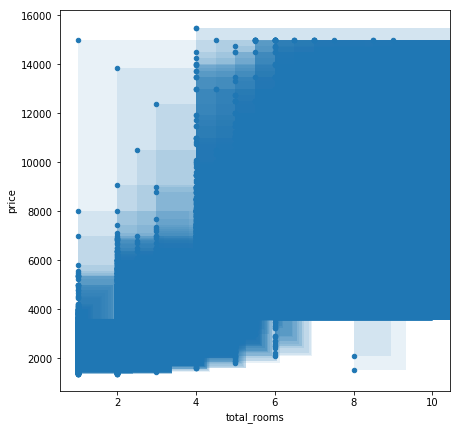

In [29]:
feature = 'total_rooms'
squared_errors(train, feature, target, m=0, b=y_train.mean())